In [ ]:
!pip install wfdb
!pip install neurokit2
import pandas as pd
import numpy as np
import wfdb
import ast
from google.colab import drive

# Mount Google Drive
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = 'ptb-xl-100hz.zip'
extraction_dir = 'ptb-xl-100hz'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extraction_dir):
    os.makedirs(extraction_dir)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extraction_dir)

print(f"Files extracted to {extraction_dir}")



Files extracted to ptb-xl-100hz


# Data Loading and Preprocessing

In [ ]:

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]

    data = np.array([signal for signal, meta in data])
    return data

# Update the path to your Google Drive
path = 'ptb-xl-100hz/ptb-xl-100hz/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0) # takes all scp statements in the file
agg_df = agg_df[agg_df.diagnostic == 1] # filters them to only include diagnostic statements

def aggregate_diagnostic(y_dic):
   # for each entry take each diagnostic statement and add to entry in temporary lsit which is returned
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
valid_fold = 9


# Train
X_train = X[np.where(Y.strat_fold <valid_fold)]
y_train = Y[(Y.strat_fold <valid_fold)].diagnostic_superclass

# Validation
X_valid = X[np.where(Y.strat_fold == valid_fold)]
y_valid = Y[(Y.strat_fold == valid_fold)].diagnostic_superclass

# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass





In [ ]:
import numpy
import copy
import torch
from torch.utils.data import DataLoader, TensorDataset
import neurokit2 as nk



def create_dataset(data, labels):

  """
  Data formatted as [R, S, L]
  R: record
  S: number of samples or sample index / features
  L: lead

  Each record has 1000 samples (as its 100hz recording over 10 seconds so 100*10)
  Each sample in the record has data for each lead.

  """

  inv_labels_map = {
      0: 'NORM',
      1: 'HYP',
      2: 'MI',
      3: 'CD',
      4: 'STTC',
  }

  labels_map = {v:k for k,v in inv_labels_map.items()}

  final_labels = []
  final_data = []
  removed = []



  for i, item in enumerate(labels.values):
    if item:

      twelve_lead = []

      for lead in range(12):
        twelve_lead.append(data[i,:,lead])


      final_labels.append(labels_map[item[0]])
      #final_data.append(nk.ecg_clean(data[i,:,:],100))
      final_data.append(twelve_lead) # DEFUNCT: For each record store it as all the samples over 1 lead. Should be reformatted as [R, S]

    else:
      removed.append(i)

  return removed, TensorDataset(torch.Tensor(np.array(final_data)), torch.LongTensor(final_labels))


leads = ['I', 'II', 'III', 'aVR' , 'aVL','aVF','V1','V2','V3','V4','V5','V6']




# for multilabel maybe do embeddings
#weight classes with the crossentropyloss torch func

In [ ]:

lead_num = 1 # defunct for multi-lead

train_removed, train_dataset = create_dataset(X_train, y_train)


valid_removed, valid_dataset = create_dataset(X_valid, y_valid)

test_removed, test_dataset = create_dataset(X_test, y_test)

# Datasets in format [R,S,L]

batch_size = 50
torch.manual_seed(1)

train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

# This splits data into [B, Rb, S, L] for X data and [B, Rb, T, L] for y data where B = number of batches, Rb = records in batch 50 until final batch  and T = label/truth
# for the case of train_dl X = [342, Rb, 1000] Rb is 50 for all but the last entry where it is 34

counts_train = torch.unique(valid_dataset.tensors[1], return_counts=True)[1]
total_train = sum(counts_train)



weighting = torch.Tensor([i/total_train for i in counts_train])



# Model Code

In [ ]:
import torch.nn as nn

class CNNBiLSTM(nn.Module):

    def __init__(self, conv_kernel, padding, drop_p, pool_size, lstm_hidden, lstm_layers):
        super().__init__()

        self.conv1 = self._convBlock(12, 32, 3, padding,drop_p) #64 filters- should have input [1000,12]

        self.conv2 = self._convBlock(32, 64, 3, padding,drop_p) # 64 filters

        self.conv3 = self._convBlock(64, 128, 3, padding,drop_p) # 64 filters

        self.conv4 = self._convBlock(128, 256, 3, padding,drop_p) # 64 filters

        #self.conv5 = self._convBlock(256, 512, 7, padding=padding)

        self.max_pool = nn.MaxPool1d(kernel_size = pool_size)

        self.bilstm = nn.LSTM(
            input_size = 256,
            hidden_size = lstm_hidden,
            num_layers = lstm_layers,
            batch_first = True,
            bidirectional = True
        )

        self.fc1 = nn.Linear(lstm_hidden*2, 128)
        self.fc2 = nn.Linear(128, 5)
        self.dropout = nn.Dropout(p=drop_p)

        self.relu = nn.ReLU(inplace=True) # inplace relu prevents in from allocating memory to a new tensor with the result of this operation. Saving memory.

        self.bn = nn.BatchNorm1d(256)


    def _convBlock(self, in_size, out_size, kernel, padding,p):
        return nn.Sequential(
            nn.Conv1d(in_size, out_size, kernel_size = kernel, padding=padding),
            nn.BatchNorm1d(out_size),
            nn.ReLU(inplace=True)
            #nn.Dropout(p),

            )



    def forward(self, x):
        x = self.conv1(x) # [1000,64]
        x = self.max_pool(x) # [500, 64] floor((1000 - (2-1)-1)/2)+1 = floor(998/2) +1 = 499 +1 = 500

        x = self.conv2(x) # [500, 128]
        x = self.max_pool(x) # [250, 128] floor((500 - (2-1)-1)/2)+1 = floor(498/2) +1 = 249 +1 = 250

        x = self.conv3(x)
        x = self.max_pool(x) # [125, 192] floor((250 - (2-1)-1)/2)+1 = floor(248/2) +1 = 124 +1 = 125

        x = self.conv4(x)
        x = self.max_pool(x) # [62, 256] floor((125 - 2)/2) + 1 = 61 + 1 = 62

        #x = self.conv5(x)
        x = self.bn(x)
        x, _ = self.bilstm(x.transpose(1,2))

        x = x[:,-1,:]

        x = self.dropout(x)

        x = self.relu(self.fc1(x))

        x = self.dropout(x)

        return self.fc2(x)







# Model Training Function

In [ ]:


def train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type=None, lam=0.01, num_epochs=50):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:

            x_batch = x_batch.cuda(non_blocking=True)
            y_batch = y_batch.cuda(non_blocking=True)

            pred = model(x_batch)

            loss = loss_fn(pred, y_batch)



            # Apply L1 regularization
            if regularisation_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lam * l1_norm

            # Apply L2 regularization
            elif regularisation_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lam * l2_norm


            loss.backward() # compute gradient based on results of all predictions made by the model given the inputs, in this case the batches

            optimiser.step()

            optimiser.zero_grad() # resets gradient

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)


        print(f'Epoch {epoch} Train_loss = {loss_hist_train[epoch]}, Valid_loss = {loss_hist_valid[epoch]}')

        del y_batch, x_batch, loss, pred
        torch.cuda.empty_cache()

    return loss_hist_train, loss_hist_valid





# Model wrapper function

In [ ]:

def estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate, regularisation, num_epochs=20):

  torch.manual_seed(1)

  train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
  valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

  model = nn.DataParallel(CNNBiLSTM(kernel_size, padding, drop_p, pool_size, 128, 1))
  model = model.to('cuda')

  loss_fn = nn.CrossEntropyLoss(weight=weighting.to('cuda'))

  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  loss_hist_train, loss_hist_valid = train_model(model, optimiser, loss_fn, train_dl, valid_dl, regularisation_type=regularisation, num_epochs=num_epochs, lam=0.0005)

  return model, loss_hist_valid[-1], loss_hist_train, loss_hist_valid


# Grid Search

In [ ]:
import itertools
from sklearn import metrics

parameter_grid = {
    'batch_size': [32, 64, 128],
    'kernel_size': [5, 9, 13],
    'pool_size': [2, 3],
    'padding': [2, 4, 6],
    'drop_p': [0.2, 0.3],
    'learning_rate': [0.0001, 0.001],
}

def grid_search(estimator, parameter_grid):

  best_val_loss = float('inf')
  best_params = {}

  best_losses = [] #0 is train 1 is valid

  best_f1 = 0

  keys = parameter_grid.keys()



  if torch.cuda.is_available():
      print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
  else:
      print("No GPU available. Training will run on CPU.")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  for values in itertools.product(*parameter_grid.values()):
      current_params = dict(zip(keys, values))

      batch_size = current_params['batch_size']
      kernel_size = current_params['kernel_size']
      pool_size = current_params['pool_size']
      padding = current_params['padding']
      drop_p = current_params['drop_p']
      learning_rate = current_params['learning_rate']

      print(f"Testing parameters: {current_params}")

      model, current_val_loss, loss_hist_train, loss_hist_valid = estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate)

      print(f"Validation Loss: {current_val_loss}")

      pred_val = torch.Tensor.cpu(model(valid_dataset.tensors[0])).detach().numpy()
      pred_val_values = np.argmax(pred_val,axis=1)

      f1_score_val = metrics.f1_score(valid_dataset.tensors[1],pred_val_values, average='macro')

      print(f"Validation f1: {f1_score_val}")

      plot_loss_history(loss_hist_train, loss_hist_valid)

      if current_val_loss < best_val_loss:
          best_val_loss = current_val_loss
          best_params = current_params
          best_f1 = f1_score_val
          best_losses = [loss_hist_train, loss_hist_valid]

  print(f"\nBest validation loss: {best_val_loss}")
  print(f"Best parameters: {best_params}")

  return best_params



# Model Training

In [ ]:
from sklearn import metrics


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

current_params = {'batch_size': 32, 'kernel_size': 9, 'pool_size': 2, 'padding': 'same', 'drop_p': 0.3, 'learning_rate': 0.0005}

batch_size = current_params['batch_size']
kernel_size = current_params['kernel_size']
pool_size = current_params['pool_size']
padding = current_params['padding']
drop_p = current_params['drop_p']
learning_rate = current_params['learning_rate']
regularisation = 'L2'

labels = ['NORM', 'HYP', 'MI', 'CD', 'STTC']

model, current_val_loss, loss_hist_train, loss_hist_valid = estimator(batch_size, kernel_size, pool_size, padding, drop_p, learning_rate, regularisation, num_epochs=20)

print(f"Validation Loss: {current_val_loss}")



GPU: NVIDIA L4 is available.
cuda
Epoch 0 Train_loss = 1.3045491769480722, Valid_loss = 0.5622219930490598
Epoch 1 Train_loss = 0.9246990067203551, Valid_loss = 0.5052437610084057
Epoch 2 Train_loss = 0.7943797838043145, Valid_loss = 0.5527844933405838
Epoch 3 Train_loss = 0.7119274683675227, Valid_loss = 0.4751090523470037
Epoch 4 Train_loss = 0.6581200552304883, Valid_loss = 0.4730114613252606
Epoch 5 Train_loss = 0.6282650312699694, Valid_loss = 0.46770948400583817
Epoch 6 Train_loss = 0.5997693606769416, Valid_loss = 0.4690467548614779
Epoch 7 Train_loss = 0.5792106448334069, Valid_loss = 0.47896956953064707
Epoch 8 Train_loss = 0.5621304275614962, Valid_loss = 0.4728041320955875
Epoch 9 Train_loss = 0.556298566852624, Valid_loss = 0.482282315140446
Epoch 10 Train_loss = 0.5379918638422293, Valid_loss = 0.4944895706994447
Epoch 11 Train_loss = 0.5274560575712985, Valid_loss = 0.45922127485497466
Epoch 12 Train_loss = 0.519952799391339, Valid_loss = 0.47550064113463264
Epoch 13 Trai

# Model Evaluation Metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_history(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



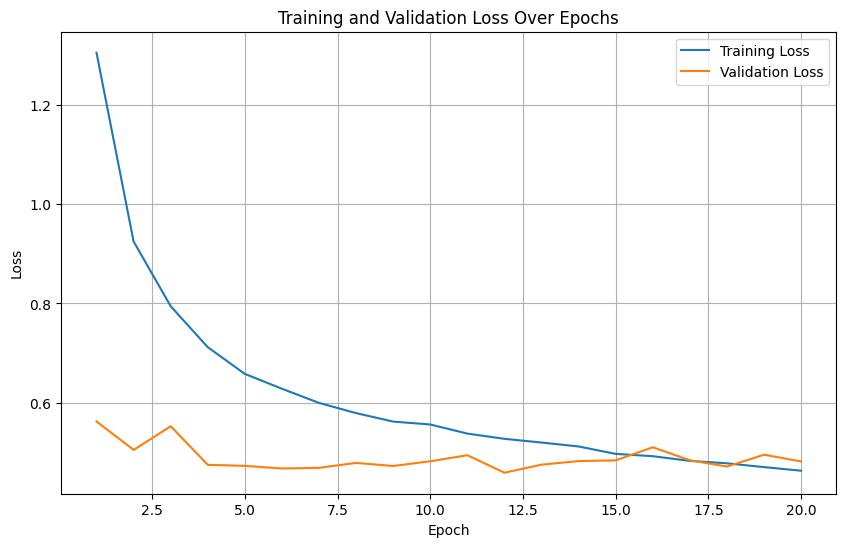

0.5489987917228658
0.5489987917228658 0.6376332219063701


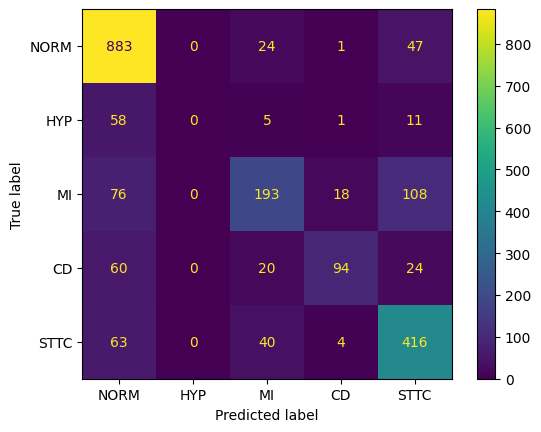

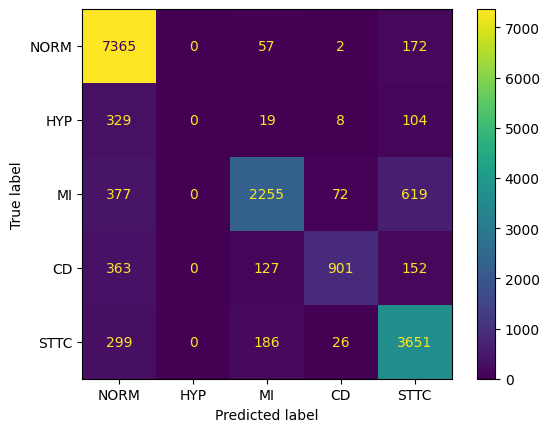

In [ ]:
#del X_test, X_train, X_valid, y_test, y_train, y_valid

with torch.no_grad():
  plot_loss_history(loss_hist_train, loss_hist_valid)

  pred_val = torch.Tensor.cpu(model(valid_dataset.tensors[0])).detach().numpy()

  pred_val_values = np.argmax(pred_val,axis=1)


  f1_score_val = metrics.f1_score(valid_dataset.tensors[1],pred_val_values, average='macro')

  print(f1_score_val)

  matrix_val = metrics.confusion_matrix(valid_dataset.tensors[1], pred_val_values, labels=[0,1,2,3,4])

  disp_val = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=labels)
  disp_val.plot()



  pred_train = torch.Tensor.cpu(model(train_dataset.tensors[0])).detach().numpy()

  pred_train_values = np.argmax(pred_train,axis=1)


  matrix_train = metrics.confusion_matrix(train_dataset.tensors[1], pred_train_values, labels=[0,1,2,3,4])

  disp_train = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix_train, display_labels=labels)
  disp_train.plot()

  f1_score_train = metrics.f1_score(train_dataset.tensors[1],pred_train_values, average='macro')


  print(f1_score_val, f1_score_train)